In [1]:
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset
import matplotlib
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcols
import glob 
import colorcet as cc
import netCDF4
import cmaps
from scipy.interpolate import interp2d
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib.gridspec as gridspec
import seaborn as sns
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyproj import Proj
# from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
from colorspacious import cspace_converter
import pathlib
from pathlib import Path
import numpy.ma as ma
from numpy import genfromtxt
import pandas as pd
import calendar
from IPython.core.pylabtools import figsize
from scipy import stats
from collections import Counter
from scipy.stats import mannwhitneyu
import sys
import os
from scipy.ndimage import convolve, minimum_filter
from scipy import ndimage


# Path to the directory containing the file
module_path = '/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Examples_Paper_Only/src_brandon_plots'

# Add it to sys.path if it's not already there
if module_path not in sys.path:
    sys.path.append(module_path)

# Now import
from retrieve_era5_fields_nc import *

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_lpt_composite_mask_file_name(year1):

    year2 = year1 + 1

    data_dir = (
        '/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/'
        + 'lpt-python-public/ar.testing7.merge_split/data/ar/g0_0h/thresh1/systems'
    )

    ymdh1 = f'{year1}060100'
    ymdh2 = f'{year2}063023'

    fn_composite_mask = f'{data_dir}/lpt_composite_mask_{ymdh1}_{ymdh2}.nc'

    return fn_composite_mask


# Objective
circle back to plot what I need for the paper after I hear from Brandon

In [3]:
non_mjo_df = pd.read_csv('/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/text_files/LE_MJO_Connected.csv')
non_mjo_df = non_mjo_df.drop(columns=['Unnamed: 0'])

filtered_df = non_mjo_df

In [5]:
#open the AR of interest that's a good test case
#bring in the ARs
non_mjo_df = pd.read_csv('/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/text_files/LE_MJO_Connected.csv')
non_mjo_df = non_mjo_df.drop(columns=['Unnamed: 0'])

filtered_df = non_mjo_df

#need to update because Brandon changed the directories
# ar_test = xr.open_dataset(filtered_df['AR ID (string)'].iloc[16])
ar_test = xr.open_dataset('/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/lpt-python-public-2024/ar.testing7.merge_split/data/ar/g0_0h/thresh1/systems/2020060100_2021063023/lpt_system_mask_ar.lptid00383.0500.nc')



In [4]:
ar_test

<xarray.Dataset>
Dimensions:                       (lat: 721, lon: 1440, time: 64, n: 1)
Coordinates:
  * n                             (n) int32 1
  * time                          (time) datetime64[ns] 2021-01-08T13:00:00 ....
  * lon                           (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
Data variables: (12/21)
    grid_area                     (lat, lon) float32 ...
    centroid_lon                  (time) float64 ...
    centroid_lat                  (time) float64 ...
    area                          (time) float64 ...
    largest_object_centroid_lon   (time) float64 ...
    largest_object_centroid_lat   (time) float64 ...
    ...                            ...
    lptid                         (n) float64 ...
    duration                      (n) float64 ...
    maxarea                       (n) float64 ...
    zonal_propagation_speed       (n) float64 ...
    meridional_propagation_speed  (n) float64 ...
    mask                          (time, lat, lon) int8 ...

In [7]:
start_dt = dt.datetime(2021,1,8,13)
end_dt = dt.datetime(2021,1,10,6)

In [8]:
plot_area = [155, 245, 5, 55]
verbose = True

## AR Start Time

In [9]:
F = retrieve_era5_fields_nc(start_dt, verbose=verbose)
lon, lat = np.meshgrid(F['lon'], F['lat'])
tpw = F['tpw']
viwve = F['viwve']
viwvn = F['viwvn']
topography = F['orog']

ivt = np.sqrt(np.power(viwve,2)+np.power(viwvn,2))
area = np.abs(111.0*111.0*0.25*0.25*np.cos(np.pi*lat/180.0))

ivt_filtered = ndimage.gaussian_laplace(ivt, [5,5], truncate=2)

# Deep Tropics Mask and TPW background
fn_ar_mask = ('/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/ar_objects/'
    + start_dt.strftime('mask_data.testing7/%Y/%m/ar%Y%m%d%H.nc'))
print(fn_ar_mask)
with xr.open_dataset(fn_ar_mask) as ds:
    deep_tropics_mask = ds['deep_tropics_mask'].data[0,:,:]



mask_ivt = ivt_filtered < -7.0
# Nerf the strong monsoon circulations:
# - Eastward IVT > 500
# - Within deep tropics mask

# mask_ivt[np.logical_and(
#     deep_tropics_mask,
#     viwve > 250.0
#     )] = 0
# mask_ivt[np.logical_and(
#     deep_tropics_mask,
#     viwve < -250.0
#     )] = 0

mask_ivt = ndimage.binary_fill_holes(mask_ivt)


def calc_tpw_background(tpw, topography):
    
    rad = int(5.0/.25)
    MAXTOPO = 500.0
    # MAXTOPO = 1000.0

    if tpw.ndim == 2:

        n_pad_y_lat = 1*rad
        tpw_padded_lat = np.append(tpw[0:n_pad_y_lat,:], tpw, axis=0)
        tpw_padded_lat = np.append(tpw_padded_lat, tpw[-1*n_pad_y_lat:,:], axis=0)
        topo_padded_lat = np.append(topography[0:n_pad_y_lat,:], topography, axis=0)
        topo_padded_lat = np.append(topo_padded_lat, topography[-1*n_pad_y_lat:,:], axis=0)

        #Effectively disregard points above the MAXTOPO elevation.
        tpw_topo_max = np.where(topo_padded_lat > MAXTOPO, 999.0, tpw_padded_lat)

        # Set the shapes used for the minimum filters
        shape_left = np.append(np.ones([1,rad]), np.zeros([1,rad+1]), axis=1)
        shape_right = np.append(np.zeros([1,rad+1]), np.ones([1,rad]), axis=1)
        shape_top = np.append(np.ones([rad,1]), np.zeros([rad+1,1]), axis=0)
        shape_bottom = np.append(np.zeros([rad+1,1]), np.ones([rad,1]), axis=0)

        # Calculate the minimum filters.
        # I'm using "wrap" mode here, but I actually only want it to wrap in the 
        # zonal direction. So I pad it in the meridional direction
        # Then remove the artificial points at the north and south edges.
        tpw_filter_left = minimum_filter(tpw_topo_max, footprint=shape_left, mode='wrap')
        tpw_filter_right = minimum_filter(tpw_topo_max, footprint=shape_right, mode='wrap')
        tpw_filter_top = minimum_filter(tpw_topo_max, footprint=shape_top, mode='wrap')
        tpw_filter_bottom = minimum_filter(tpw_topo_max, footprint=shape_bottom, mode='wrap')

        # Combine the minimum filters to get the full background TPW.
        tpw_filter_left_right = np.maximum(tpw_filter_left, tpw_filter_right)
        tpw_filter_top_bottom = np.maximum(tpw_filter_top, tpw_filter_bottom)

        tpw_filter_all = np.minimum(tpw_filter_left_right, tpw_filter_top_bottom)

        # Throw away the data where I stitched at the north and south edges.
        tpw_filter_all = tpw_filter_all[n_pad_y_lat:-1*n_pad_y_lat,:]

        # I don't have a background TPW for high topography.
        # Therefore, set it to the original TPW.
        # That way when I calculate the difference from the background,
        # I will get zero.
        tpw_filter_all = np.where(tpw_filter_all > 998.0, tpw, tpw_filter_all)

        # Set the background TPW.
        return tpw_filter_all

tpw_background = calc_tpw_background(tpw, topography)


/home/orca/data/model_anal/era5/from_rda/tcwv/e5.oper.an.sfc.128_137_tcwv.ll025sc.2021010100_2021013123.nc
/home/orca/data/model_anal/era5/from_rda/viwve/e5.oper.an.vinteg.162_071_viwve.ll025sc.2021010100_2021013123.nc
/home/orca/data/model_anal/era5/from_rda/viwvn/e5.oper.an.vinteg.162_072_viwvn.ll025sc.2021010100_2021013123.nc
/home/orca/data/model_anal/era5/from_rda/v_200mb/2021/01/e5.oper.an.pl.128_132_v.ll025uv.2021010800_2021010823.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/u_200mb/2021/01/e5.oper.an.pl.128_131_u.ll025uv.2021010800_2021010823.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/invariant/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc
/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/ar_objects/mask_data.testing7/2021/01/ar2021010813.nc


/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

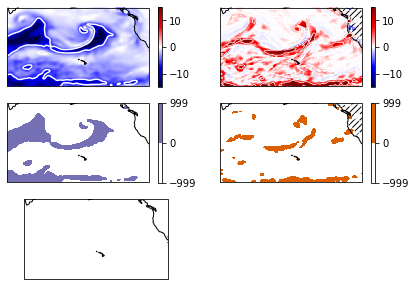

In [13]:
fig = plt.figure(figsize=[7,5])
dt1 = start_dt

ax1 = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.set_extent(plot_area, crs=ccrs.PlateCarree())

H1 = ax1.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15, cmap='seismic', transform=ccrs.PlateCarree())
ax1.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='w', linestyles='-', transform=ccrs.PlateCarree())

plt.colorbar(H1)





# TPW
ax2 = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2.coastlines()
ax2.set_extent(plot_area, crs=ccrs.PlateCarree())

# H2 = ax2.pcolormesh(lon, lat, tpw_background,
#     vmin=0.0, vmax=60.0, cmap='cet_rainbow4', transform=ccrs.PlateCarree())
H2 = ax2.pcolormesh(lon, lat, tpw - tpw_background,
    vmin=-15.0, vmax=15.0, cmap='seismic', transform=ccrs.PlateCarree())

tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5*tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax2.contour(lon, lat, tpw_mask,
    levels=[0.5,], colors='w', linewidths=0.7, transform=ccrs.PlateCarree())

plt.colorbar(H2)

ax2.contourf(lon, lat, topography, levels=[1000, 9999], colors=['none',], hatches=['////',], transform=ccrs.PlateCarree())



## Mask showing the final IVT mask

ax3 = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree(central_longitude=180.0))
ax3.coastlines()
ax3.set_extent(plot_area, crs=ccrs.PlateCarree())

# IVT Mask
H3 = ax3.contourf(lon, lat, mask_ivt, levels=[-999.0,0.5,999.0],
    colors = ['none','#7570b3'], transform=ccrs.PlateCarree())

plt.colorbar(H3)

# ax3.contour(lon, lat, viwve, levels=[-250, 250,], colors='r', linestyles='-', transform=ccrs.PlateCarree())

# exclude_ivt_tropics = np.logical_and(deep_tropics_mask, np.abs(viwve) > 250)
# ax3.contourf(lon, lat, exclude_ivt_tropics, levels=[0.5, 9999], colors=['none',], hatches=['////',], transform=ccrs.PlateCarree())



## TPW Mask
ax4 = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4.coastlines()
ax4.set_extent(plot_area, crs=ccrs.PlateCarree())
# # ax2.set_extent([120, 260, 0, 60], crs=ccrs.PlateCarree())
# H = ax3.pcolormesh(lon, lat, ivt_filtered, vmin=-20, vmax=20, cmap='cet_rainbow4', transform=ccrs.PlateCarree())
# ax3.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='w', linestyles='-', transform=ccrs.PlateCarree())
# ax3.contour(lon, lat, viwve, levels=[250,], colors='r', linestyles='-', transform=ccrs.PlateCarree())

# IVT Mask
H4 = ax4.contourf(lon, lat, tpw_mask, levels=[-999.0,0.5,999.0],
    colors = ['none','#d95f02'], transform=ccrs.PlateCarree())

plt.colorbar(H4)

ax4.contourf(lon, lat, topography, levels=[1000, 9999], colors=['none',], hatches=['////',], transform=ccrs.PlateCarree())


### Combined mask
ax5 = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5.coastlines()
ax5.set_extent(plot_area, crs=ccrs.PlateCarree())

year1 = dt1.year
fn_mask = get_lpt_composite_mask_file_name(year1)
with xr.open_dataset(fn_mask) as ds:
    ds_this_time = ds.sel(time=dt1)
    ar_system_mask = ds_this_time['mask'].data


H5 = ax5.contourf(lon, lat, ar_system_mask, levels=[0.5, 999],
    colors=['darkgrey',], transform=ccrs.PlateCarree())

plt.colorbar(H5)


ax5.contour(lon, lat, mask_ivt, levels=[0.5,],
    # colors='#66c2a5', alpha=0.5, transform=ccrs.PlateCarree())
    # colors='#1b9e77', alpha=0.5, transform=ccrs.PlateCarree())
    colors='#7570b3', linewidths=0.7, transform=ccrs.PlateCarree())


# H4 = ax4.contourf(lon, lat, tpw_mask, levels=[-999.0,0.5,999.0],
#     colors = ['none','green'], transform=ccrs.PlateCarree())
ax5.contour(lon, lat, tpw_mask, levels=[0.5,],
    # colors = '#8da0cb', transform=ccrs.PlateCarree())
    # colors = '#7570b3', transform=ccrs.PlateCarree())
    colors = '#d95f02', linewidths=0.7, transform=ccrs.PlateCarree())

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.contour(lon, lat, deep_tropics_mask, levels=[0.5,],
        colors=['k',], linestyles='--', transform=ccrs.PlateCarree())

def add_panel_label(ax, label):
    ax.text(0.05, 1.05, label, transform=ax.transAxes)

add_panel_label(ax1, 'a.')
add_panel_label(ax2, 'b.')
add_panel_label(ax3, 'c.')
add_panel_label(ax4, 'd.')
add_panel_label(ax5, 'e.')

# plt.savefig('ivt_and_tpw_mask.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
year1

2021

In [ ]:
#let's try to replot these one by one until I get an image that works

H1 = ax1.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15, cmap='seismic', transform=ccrs.PlateCarree())
ax1.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='w', linestyles='-', transform=ccrs.PlateCarree())

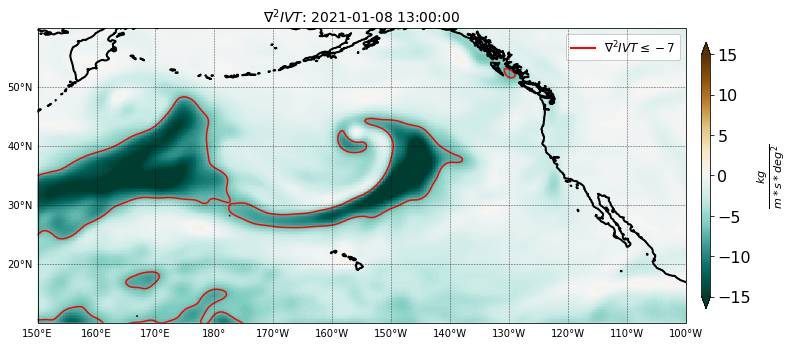

In [12]:
dt1 = start_dt
cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.MPL_BrBG_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

ax.set_title(r'$\nabla^2 IVT$: '+str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())

css =ax.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15, cmap=colormap, transform=ccrs.PlateCarree())
ax.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='red', linestyles='-', transform=ccrs.PlateCarree(), linewidth=2)

cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\frac{kg}{m*s*deg^2}$', fontsize=16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')

ax.legend(handles=[solid_line], loc='upper right', fontsize=12, frameon=True, ncol=2, framealpha=1.0)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
# ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/Start_AR_Track_IVT_Lapl.png", dpi=350, bbox_inches='tight')
plt.show()

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


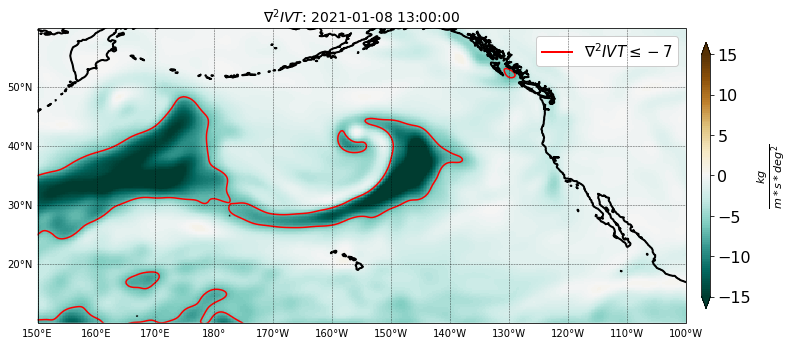

In [22]:
#plot 1

dt1 = start_dt
cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.MPL_BrBG_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

ax.set_title(r'$\nabla^2 IVT$: '+str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())

css =ax.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15, cmap=colormap, transform=ccrs.PlateCarree())
ax.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='red', linestyles='-', transform=ccrs.PlateCarree(), linewidth=2)

cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\frac{kg}{m*s*deg^2}$', fontsize=16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')

ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
# ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
# fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/Start_AR_Track_IVT_Lapl.png", dpi=350, bbox_inches='tight')
plt.show()

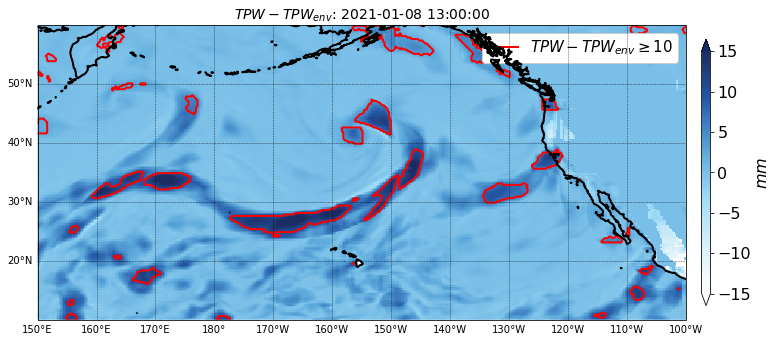

In [21]:
#let's plot the TPW field
#plot 2
cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.WhiteBlue

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

ax.set_title(r'$TPW - TPW_{env}$: '+str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())

css =ax.pcolormesh(lon, lat, tpw - tpw_background,
    vmin=-15.0, vmax=15.0, cmap=colormap, transform=ccrs.PlateCarree())

tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5*tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax.contour(lon, lat, tpw_mask,
    levels=[0.5,], colors='red', linewidths=2, transform=ccrs.PlateCarree())


cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$mm$', fontsize=16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')

ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
# ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/Start_AR_Track_TPW_Diff.png", dpi=350, bbox_inches='tight')
plt.show()

In [12]:
#bring in the composite AR mask data for this time

ar_comp_ds = xr.open_dataset('/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/lpt-python-public-2024/ar.testing7.merge_split/data/ar/g0_0h/thresh1/systems/lpt_composite_mask_2020060100_2021063023.nc')
ar_comp_array=ar_comp_ds['mask']

In [13]:
#slice for the datetime of interest
TimeIndexer = 'time'
ar_comp_slice = ar_comp_array.sel(**{TimeIndexer: slice(dt1, dt1)})

In [14]:
ar_comp_slice

<xarray.DataArray 'mask' (time: 1, lat: 721, lon: 1440)>
[1038240 values with dtype=int8]
Coordinates:
  * time     (time) datetime64[ns] 2021-01-08T13:00:00
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Attributes:
    units:    1

In [15]:
ar_comp_slice[0].shape

(721, 1440)

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


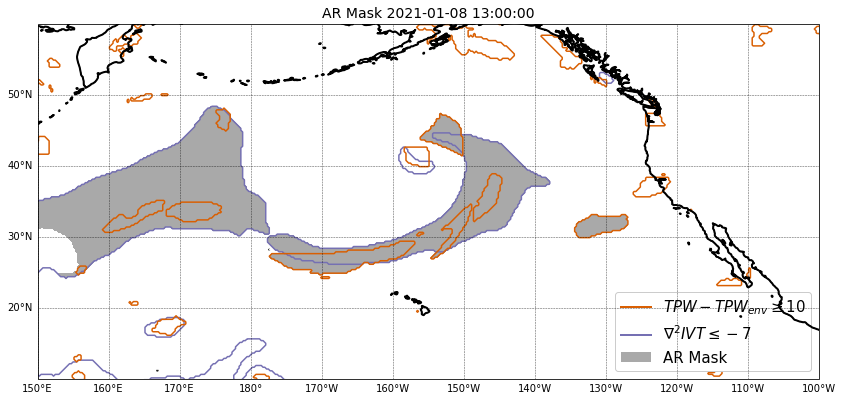

In [20]:
#let's plot the Combined AR

#plot 3
cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.WhiteBlue

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

ax.set_title('AR Mask '+str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())

css =ax.contourf(ar_comp_slice['lon'], ar_comp_slice['lat'], ar_comp_slice[0], levels=[0.5, 999],
    colors=['darkgrey',], transform=ccrs.PlateCarree(),linewidths=2)

ax.contour(lon, lat, mask_ivt, levels=[0.5,],
    # colors='#66c2a5', alpha=0.5, transform=ccrs.PlateCarree())
    # colors='#1b9e77', alpha=0.5, transform=ccrs.PlateCarree())
    colors='#7570b3', linewidths=1.5, transform=ccrs.PlateCarree())

ax.contour(lon, lat, tpw_mask, levels=[0.5,],
    # colors = '#8da0cb', transform=ccrs.PlateCarree())
    # colors = '#7570b3', transform=ccrs.PlateCarree())
    colors = '#d95f02', linewidths=1.5, transform=ccrs.PlateCarree())


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',aspect=30, shrink=0.7, pad=0.06, extend='both')
# cbar.ax.tick_params(labelsize=16)
# cbar.set_label(r'$mm$', fontsize=16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

tpw_legend = Line2D([0], [0], color='#d95f02', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
IVT_legend = Line2D([0], [0], color='#7570b3', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
AR_legend = Patch(
    facecolor='darkgrey',  # Fill color
    label='AR Mask' 
)
ax.legend(handles=[tpw_legend,IVT_legend,AR_legend], loc='lower right', fontsize=15, frameon=True, ncol=1, framealpha=1.0)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
# ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
# fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/Start_AR_Track_Fin_Mask.png", dpi=350, bbox_inches='tight')
plt.show()

#NEED TO ADD LEGEND

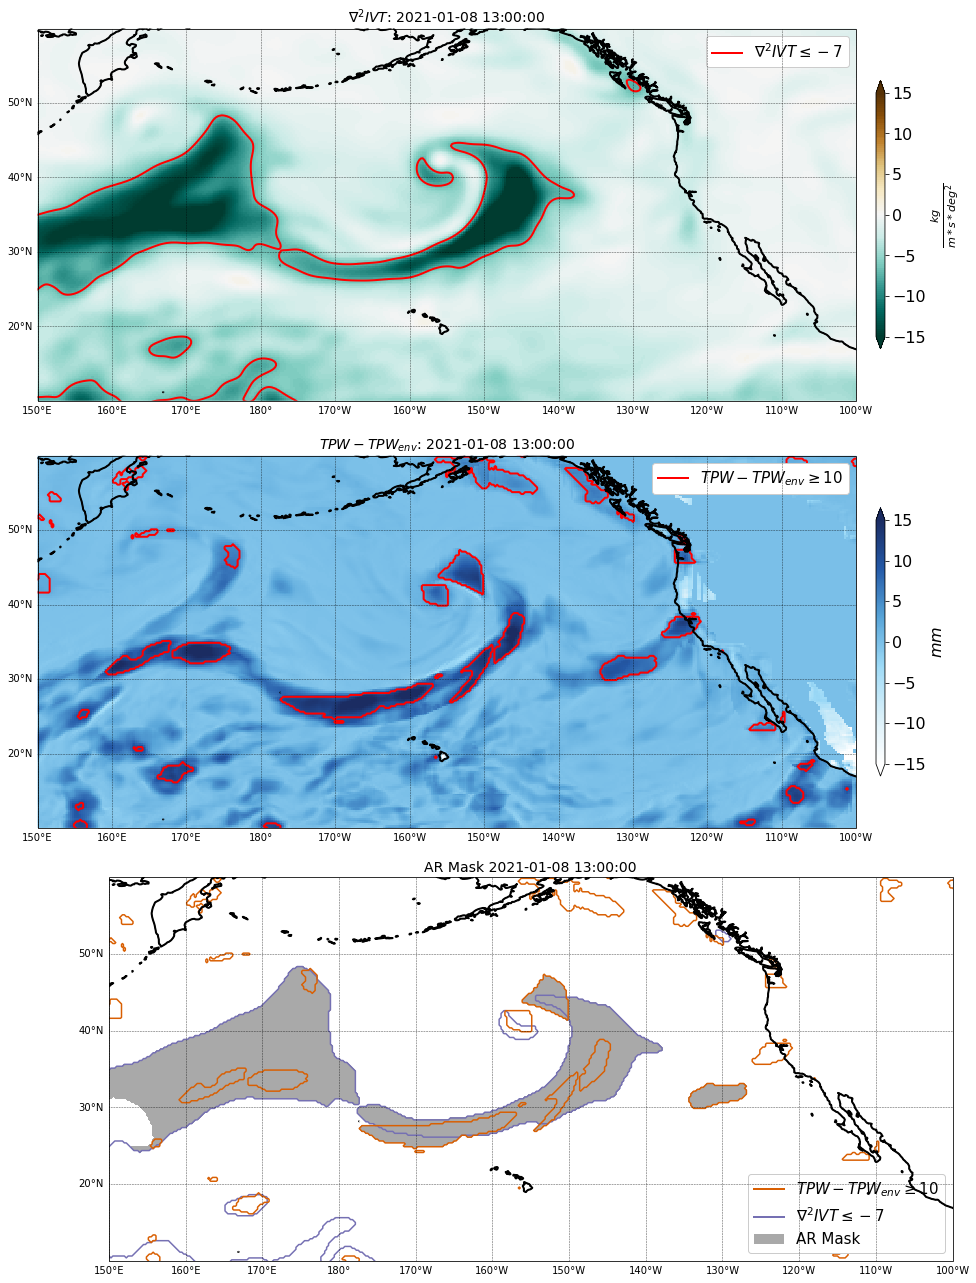

In [35]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from cartopy.feature import NaturalEarthFeature
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# import matplotlib.ticker as mticker
# import cmaps
# import numpy as np

cm = 180
minlon = 80 + cm
maxlon = -30 + cm
proj = ccrs.PlateCarree(central_longitude=cm)

# Create subplots: 3 rows, 1 column
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 18),
                        subplot_kw={'projection': proj})

political_boundaries = NaturalEarthFeature(category='cultural',
                                           name='admin_0_boundary_lines_land',
                                           scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                             name='admin_1_states_provinces_lakes',
                             scale='50m', facecolor='none')

##############################################
# 1. PLOT: ∇²IVT Filtered
##############################################
ax = axs[0]
ax.set_title(r'$\nabla^2 IVT$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.MPL_BrBG_r
css = ax.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15,
                    cmap=colormap, transform=ccrs.PlateCarree())

ax.contour(lon, lat, ivt_filtered, levels=[-7.0], colors='red',
           linestyles='-', transform=ccrs.PlateCarree(), linewidths=2)

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\frac{kg}{m*s*deg^2}$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# 2. PLOT: AR Mask Composite
##############################################
ax = axs[2]
ax.set_title('AR Mask '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue

# AR region mask shading
ax.contourf(ar_comp_slice['lon'], ar_comp_slice['lat'], ar_comp_slice[0],
            levels=[0.5, 999], colors=['darkgrey'], transform=ccrs.PlateCarree())

# IVT mask
ax.contour(lon, lat, mask_ivt, levels=[0.5], colors='#7570b3',
           linewidths=1.5, transform=ccrs.PlateCarree())

# TPW mask
ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='#d95f02',
           linewidths=1.5, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

# Legend
tpw_legend = Line2D([0], [0], color='#d95f02', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ivt_legend = Line2D([0], [0], color='#7570b3', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ar_patch = Patch(facecolor='darkgrey', label='AR Mask')

ax.legend(handles=[tpw_legend, ivt_legend, ar_patch], loc='lower right', fontsize=15,
          frameon=True, ncol=1, framealpha=1.0)

##############################################
# 3. PLOT: TPW - TPW_env
##############################################
ax = axs[1]
ax.set_title(r'$TPW - TPW_{env}$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue
css = ax.pcolormesh(lon, lat, tpw - tpw_background, vmin=-15.0, vmax=15.0,
                    cmap=colormap, transform=ccrs.PlateCarree())

# TPW thresholds
tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5 * tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='red',
           linewidths=2, transform=ccrs.PlateCarree())

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$mm$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# Final adjustments
##############################################
fig.subplots_adjust(hspace=0.25)
plt.tight_layout()
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/Start_All_Plots.png", dpi=350, bbox_inches='tight')
plt.show()


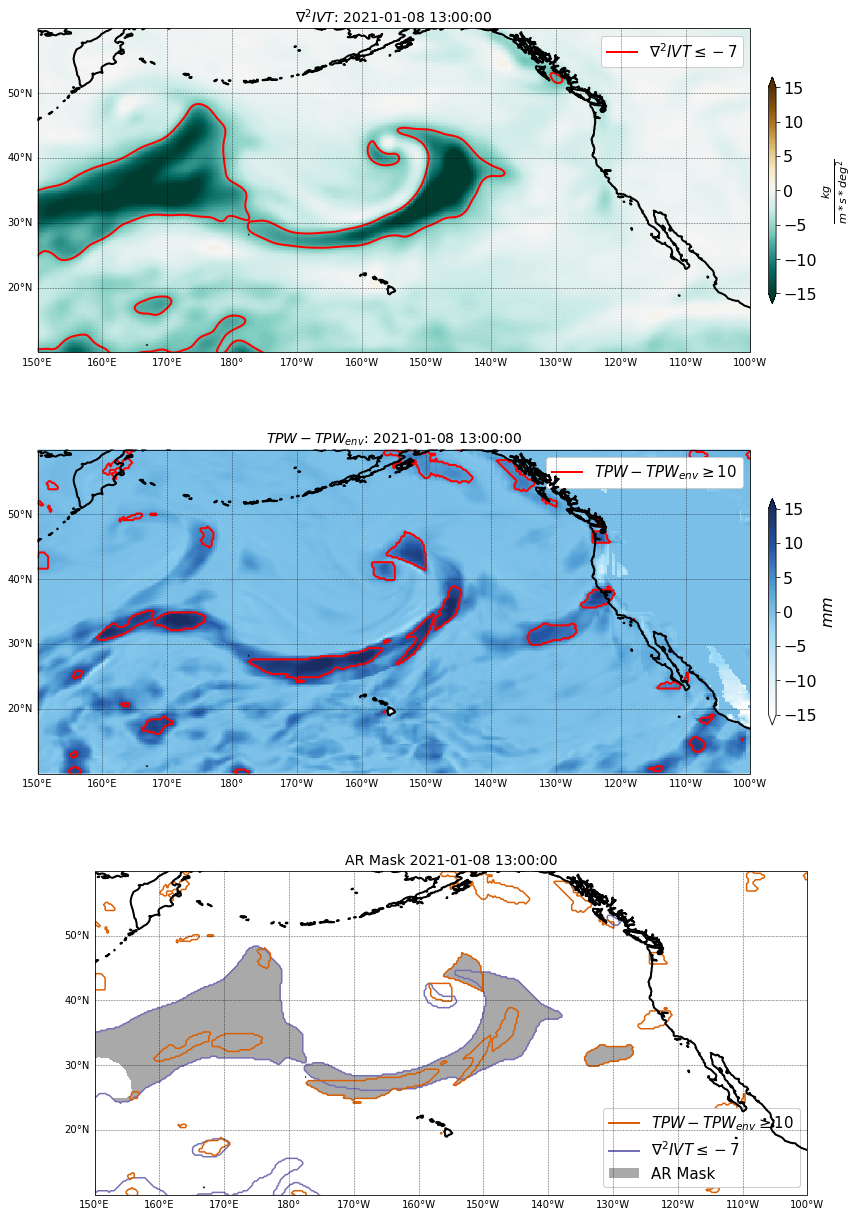

In [26]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from cartopy.feature import NaturalEarthFeature
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# import matplotlib.ticker as mticker
# import cmaps
# import numpy as np

cm = 180
minlon = 80 + cm
maxlon = -30 + cm
proj = ccrs.PlateCarree(central_longitude=cm)

# Use constrained_layout for better alignment
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 18),
                        subplot_kw={'projection': proj},
                        gridspec_kw={'hspace': 0.3})

political_boundaries = NaturalEarthFeature(category='cultural',
                                           name='admin_0_boundary_lines_land',
                                           scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                             name='admin_1_states_provinces_lakes',
                             scale='50m', facecolor='none')

##############################################
# 1. PLOT: ∇²IVT Filtered
##############################################
ax = axs[0]
ax.set_title(r'$\nabla^2 IVT$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.MPL_BrBG_r
css = ax.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15,
                    cmap=colormap, transform=ccrs.PlateCarree())

ax.contour(lon, lat, ivt_filtered, levels=[-7.0], colors='red',
           linestyles='-', transform=ccrs.PlateCarree(), linewidths=2)

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\frac{kg}{m*s*deg^2}$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# 2. PLOT: TPW - TPW_env
##############################################
ax = axs[1]
ax.set_title(r'$TPW - TPW_{env}$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue
css = ax.pcolormesh(lon, lat, tpw - tpw_background, vmin=-15.0, vmax=15.0,
                    cmap=colormap, transform=ccrs.PlateCarree())

# TPW thresholds
tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5 * tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='red',
           linewidths=2, transform=ccrs.PlateCarree())

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$mm$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# 3. PLOT: AR Mask Composite (Bottom Plot)
##############################################
ax = axs[2]
ax.set_title('AR Mask '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue

# AR region mask shading
ax.contourf(ar_comp_slice['lon'], ar_comp_slice['lat'], ar_comp_slice[0],
            levels=[0.5, 999], colors=['darkgrey'], transform=ccrs.PlateCarree())

# IVT mask
ax.contour(lon, lat, mask_ivt, levels=[0.5], colors='#7570b3',
           linewidths=1.5, transform=ccrs.PlateCarree())

# TPW mask
ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='#d95f02',
           linewidths=1.5, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

tpw_legend = Line2D([0], [0], color='#d95f02', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ivt_legend = Line2D([0], [0], color='#7570b3', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ar_patch = Patch(facecolor='darkgrey', label='AR Mask')

ax.legend(handles=[tpw_legend, ivt_legend, ar_patch], loc='lower right', fontsize=15,
          frameon=True, ncol=1, framealpha=1.0)

##############################################
# Final adjustments
##############################################
plt.subplots_adjust(hspace=0.35, top=0.95, bottom=0.05, left=0.05, right=0.95)
plt.show()


<ipython-input-34-664776ea3af3>:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


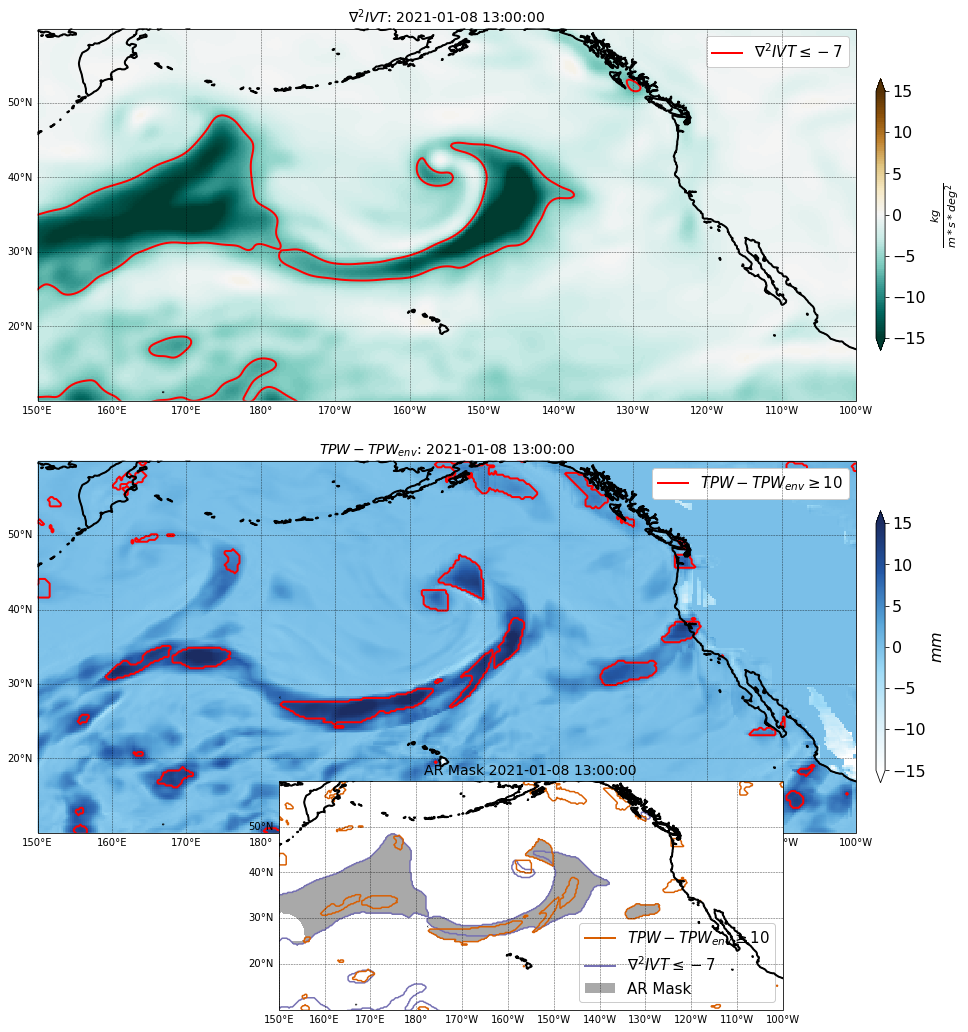

In [34]:
# import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from cartopy.feature import NaturalEarthFeature
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# import matplotlib.ticker as mticker
# import cmaps
# import numpy as np

cm = 180
minlon = 80 + cm
maxlon = -30 + cm
proj = ccrs.PlateCarree(central_longitude=cm)

# Create grid layout: 3 rows, 3 columns
fig = plt.figure(figsize=(14, 18))
gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1])

# Row 0 (full width)
ax1 = fig.add_subplot(gs[0, :], projection=proj)
# Row 1 (full width)
ax2 = fig.add_subplot(gs[1, :], projection=proj)
# Row 2 (centered by spanning 1 column in middle)
# ax3 = fig.add_subplot(gs[2, :], projection=proj)  # <-- Centered by using column 1 of 3
ax3 = fig.add_axes([0.25, 0.05, 0.5, 0.5], projection=proj)

##############################################
# 1. ∇²IVT Filtered
##############################################
ax = ax1
ax.set_title(r'$\nabla^2 IVT$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.MPL_BrBG_r
css = ax.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15,
                    cmap=colormap, transform=ccrs.PlateCarree())
ax.contour(lon, lat, ivt_filtered, levels=[-7.0], colors='red',
           linestyles='-', transform=ccrs.PlateCarree(), linewidths=2)

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\frac{kg}{m*s*deg^2}$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# 2. TPW - TPW_env
##############################################
ax = ax2
ax.set_title(r'$TPW - TPW_{env}$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue
css = ax.pcolormesh(lon, lat, tpw - tpw_background, vmin=-15.0, vmax=15.0,
                    cmap=colormap, transform=ccrs.PlateCarree())

tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5 * tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='red',
           linewidths=2, transform=ccrs.PlateCarree())

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$mm$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# 3. AR Mask Composite (centered)
##############################################
ax = ax3
ax.set_title('AR Mask '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue
ax.contourf(ar_comp_slice['lon'], ar_comp_slice['lat'], ar_comp_slice[0],
            levels=[0.5, 999], colors=['darkgrey'], transform=ccrs.PlateCarree())

ax.contour(lon, lat, mask_ivt, levels=[0.5], colors='#7570b3',
           linewidths=1.5, transform=ccrs.PlateCarree())

ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='#d95f02',
           linewidths=1.5, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

tpw_legend = Line2D([0], [0], color='#d95f02', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ivt_legend = Line2D([0], [0], color='#7570b3', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ar_patch = Patch(facecolor='darkgrey', label='AR Mask')

ax.legend(handles=[tpw_legend, ivt_legend, ar_patch], loc='lower right', fontsize=15,
          frameon=True, ncol=1, framealpha=1.0)

# Tight layout and show
fig.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()


In [ ]:
#let's try to get the combined data now

year1 = 2003 #dt1.year
fn_mask = get_lpt_composite_mask_file_name(year1)
with xr.open_dataset(fn_mask) as ds:
    ds_this_time = ds.sel(time=dt1)
    ar_system_mask = ds_this_time['mask'].data


H5 = ax5.contourf(lon, lat, ar_system_mask, levels=[0.5, 999],
    colors=['darkgrey',], transform=ccrs.PlateCarree())

plt.colorbar(H5)


ax5.contour(lon, lat, mask_ivt, levels=[0.5,],
    # colors='#66c2a5', alpha=0.5, transform=ccrs.PlateCarree())
    # colors='#1b9e77', alpha=0.5, transform=ccrs.PlateCarree())
    colors='#7570b3', linewidths=0.7, transform=ccrs.PlateCarree())


# H4 = ax4.contourf(lon, lat, tpw_mask, levels=[-999.0,0.5,999.0],
#     colors = ['none','green'], transform=ccrs.PlateCarree())
ax5.contour(lon, lat, tpw_mask, levels=[0.5,],
    # colors = '#8da0cb', transform=ccrs.PlateCarree())
    # colors = '#7570b3', transform=ccrs.PlateCarree())
    colors = '#d95f02', linewidths=0.7, transform=ccrs.PlateCarree())

In [ ]:

cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.cmocean_gray_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))


ax.set_title(str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())
# ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('orange',), transform=ccrs.PlateCarree(),zorder=5, vmin=0,linewidths=4)
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('red',), transform=ccrs.PlateCarree(),zorder=12, vmin=0,linewidths=3)
# cdssss=ax.contour(lon_ivt, lat_ivt, gaussian_filter(plt_ivt, 2, mode='reflect'), levels=np.arange(250,1500, 250), colors='blue', linewidths=1.0, zorder=10, alpha = .6)
# ax.contour(lon_ivt, lat_ivt, plt_ivt, [125], colors='blue', linewidths=1.0, zorder=10, alpha = .6)
css = ax.pcolormesh(lon_tpw, lat_tpw, plt_tpw, cmap = colormap, transform=ccrs.PlateCarree(),zorder=2, vmin=10,vmax=80)
Q = ax.quiver(X[::skipx], Y[::skipy], U_filtered[::skipy,::skipx], V_filtered[::skipy,::skipx]
        , color='b', transform=ccrs.PlateCarree()
        , scale=scale, units='inches', zorder=11, alpha=.5)

cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, shrink=0.7, pad=0.06, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('mm', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

# plt.clabel(cdssss, inline = True,
#    fontsize=8, fmt='%1.2f', colors = 'blue', zorder=10)
# qk = ax.quiverkey(Q, 0.10, 0.95, 10, '1000 kg/m/s', labelpos='E', transform=ccrs.PlateCarree())

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
plt.show()

In [ ]:
#for environmental TPW
H2 = ax2.pcolormesh(lon, lat, tpw - tpw_background,
    vmin=-15.0, vmax=15.0, cmap='seismic', transform=ccrs.PlateCarree())

tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5*tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax2.contour(lon, lat, tpw_mask,
    levels=[0.5,], colors='w', linewidths=0.7, transform=ccrs.PlateCarree())

## AR End Time

In [36]:
F = retrieve_era5_fields_nc(end_dt, verbose=verbose)
lon, lat = np.meshgrid(F['lon'], F['lat'])
tpw = F['tpw']
viwve = F['viwve']
viwvn = F['viwvn']
topography = F['orog']

ivt = np.sqrt(np.power(viwve,2)+np.power(viwvn,2))
area = np.abs(111.0*111.0*0.25*0.25*np.cos(np.pi*lat/180.0))

ivt_filtered = ndimage.gaussian_laplace(ivt, [5,5], truncate=2)

# Deep Tropics Mask and TPW background
fn_ar_mask = ('/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/ar_objects/'
    + end_dt.strftime('mask_data.testing7/%Y/%m/ar%Y%m%d%H.nc'))
print(fn_ar_mask)
with xr.open_dataset(fn_ar_mask) as ds:
    deep_tropics_mask = ds['deep_tropics_mask'].data[0,:,:]



mask_ivt = ivt_filtered < -7.0
# Nerf the strong monsoon circulations:
# - Eastward IVT > 500
# - Within deep tropics mask

# mask_ivt[np.logical_and(
#     deep_tropics_mask,
#     viwve > 250.0
#     )] = 0
# mask_ivt[np.logical_and(
#     deep_tropics_mask,
#     viwve < -250.0
#     )] = 0

mask_ivt = ndimage.binary_fill_holes(mask_ivt)


def calc_tpw_background(tpw, topography):
    
    rad = int(5.0/.25)
    MAXTOPO = 500.0
    # MAXTOPO = 1000.0

    if tpw.ndim == 2:

        n_pad_y_lat = 1*rad
        tpw_padded_lat = np.append(tpw[0:n_pad_y_lat,:], tpw, axis=0)
        tpw_padded_lat = np.append(tpw_padded_lat, tpw[-1*n_pad_y_lat:,:], axis=0)
        topo_padded_lat = np.append(topography[0:n_pad_y_lat,:], topography, axis=0)
        topo_padded_lat = np.append(topo_padded_lat, topography[-1*n_pad_y_lat:,:], axis=0)

        #Effectively disregard points above the MAXTOPO elevation.
        tpw_topo_max = np.where(topo_padded_lat > MAXTOPO, 999.0, tpw_padded_lat)

        # Set the shapes used for the minimum filters
        shape_left = np.append(np.ones([1,rad]), np.zeros([1,rad+1]), axis=1)
        shape_right = np.append(np.zeros([1,rad+1]), np.ones([1,rad]), axis=1)
        shape_top = np.append(np.ones([rad,1]), np.zeros([rad+1,1]), axis=0)
        shape_bottom = np.append(np.zeros([rad+1,1]), np.ones([rad,1]), axis=0)

        # Calculate the minimum filters.
        # I'm using "wrap" mode here, but I actually only want it to wrap in the 
        # zonal direction. So I pad it in the meridional direction
        # Then remove the artificial points at the north and south edges.
        tpw_filter_left = minimum_filter(tpw_topo_max, footprint=shape_left, mode='wrap')
        tpw_filter_right = minimum_filter(tpw_topo_max, footprint=shape_right, mode='wrap')
        tpw_filter_top = minimum_filter(tpw_topo_max, footprint=shape_top, mode='wrap')
        tpw_filter_bottom = minimum_filter(tpw_topo_max, footprint=shape_bottom, mode='wrap')

        # Combine the minimum filters to get the full background TPW.
        tpw_filter_left_right = np.maximum(tpw_filter_left, tpw_filter_right)
        tpw_filter_top_bottom = np.maximum(tpw_filter_top, tpw_filter_bottom)

        tpw_filter_all = np.minimum(tpw_filter_left_right, tpw_filter_top_bottom)

        # Throw away the data where I stitched at the north and south edges.
        tpw_filter_all = tpw_filter_all[n_pad_y_lat:-1*n_pad_y_lat,:]

        # I don't have a background TPW for high topography.
        # Therefore, set it to the original TPW.
        # That way when I calculate the difference from the background,
        # I will get zero.
        tpw_filter_all = np.where(tpw_filter_all > 998.0, tpw, tpw_filter_all)

        # Set the background TPW.
        return tpw_filter_all

tpw_background = calc_tpw_background(tpw, topography)


/home/orca/data/model_anal/era5/from_rda/tcwv/e5.oper.an.sfc.128_137_tcwv.ll025sc.2021010100_2021013123.nc
/home/orca/data/model_anal/era5/from_rda/viwve/e5.oper.an.vinteg.162_071_viwve.ll025sc.2021010100_2021013123.nc
/home/orca/data/model_anal/era5/from_rda/viwvn/e5.oper.an.vinteg.162_072_viwvn.ll025sc.2021010100_2021013123.nc
/home/orca/data/model_anal/era5/from_rda/v_200mb/2021/01/e5.oper.an.pl.128_132_v.ll025uv.2021011000_2021011023.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/u_200mb/2021/01/e5.oper.an.pl.128_131_u.ll025uv.2021011000_2021011023.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/invariant/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc
/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/ar_objects/mask_data.testing7/2021/01/ar2021011006.nc


/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


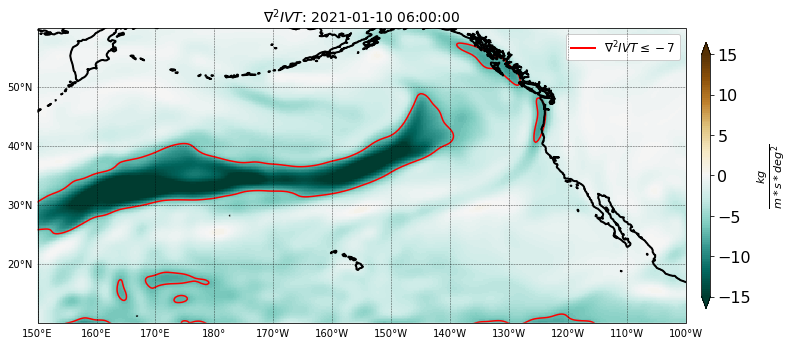

In [37]:
dt1 = end_dt
cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.MPL_BrBG_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

ax.set_title(r'$\nabla^2 IVT$: '+str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())

css =ax.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15, cmap=colormap, transform=ccrs.PlateCarree())
ax.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='red', linestyles='-', transform=ccrs.PlateCarree(), linewidth=2)

cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\frac{kg}{m*s*deg^2}$', fontsize=16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')

ax.legend(handles=[solid_line], loc='upper right', fontsize=12, frameon=True, ncol=2, framealpha=1.0)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
# ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
# fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/End_AR_Track_IVT_Lapl.png", dpi=350, bbox_inches='tight')
plt.show()

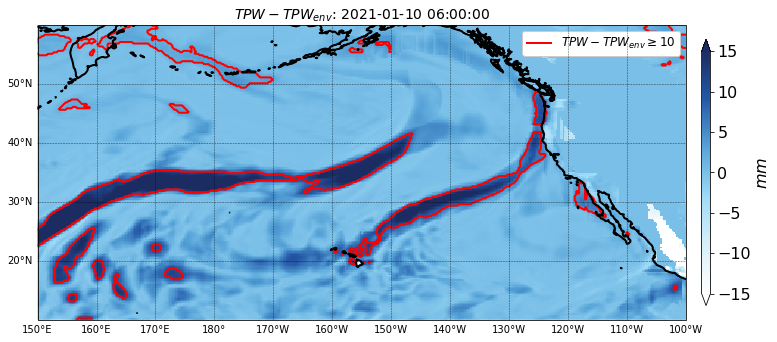

In [38]:
#let's plot the TPW field

cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.WhiteBlue

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

ax.set_title(r'$TPW - TPW_{env}$: '+str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())

css =ax.pcolormesh(lon, lat, tpw - tpw_background,
    vmin=-15.0, vmax=15.0, cmap=colormap, transform=ccrs.PlateCarree())

tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5*tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax.contour(lon, lat, tpw_mask,
    levels=[0.5,], colors='red', linewidths=2, transform=ccrs.PlateCarree())


cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$mm$', fontsize=16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')

ax.legend(handles=[solid_line], loc='upper right', fontsize=12, frameon=True, ncol=2, framealpha=1.0)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
# ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
# fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/End_AR_Track_TPW_Diff.png", dpi=350, bbox_inches='tight')
plt.show()

In [39]:
#slice for the datetime of interest
TimeIndexer = 'time'
ar_comp_slice = ar_comp_array.sel(**{TimeIndexer: slice(dt1, dt1)})

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


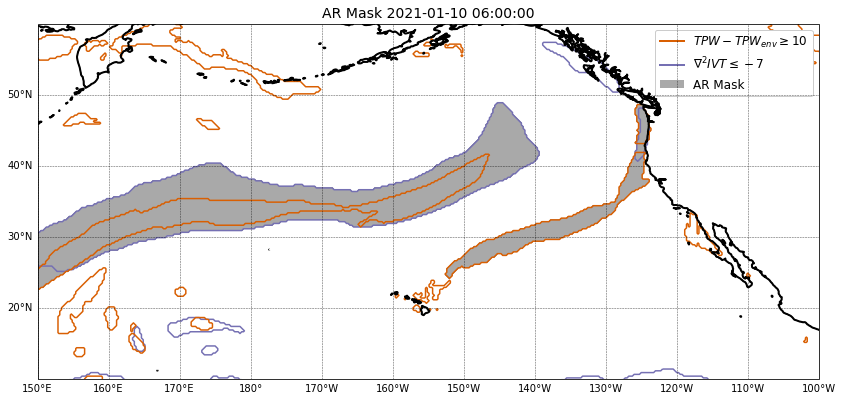

In [40]:
#let's plot the Combined AR

cm = 180
# colormap = cmaps.matlab_jet
colormap=cmaps.WhiteBlue

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

ax.set_title('AR Mask '+str(dt1), fontsize=14)					   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

minlon = 80 + cm
maxlon = -30 + cm #more negative here moves more west!!

ax.set_extent([minlon, maxlon, 10, 60], ccrs.PlateCarree())

css =ax.contourf(ar_comp_slice['lon'], ar_comp_slice['lat'], ar_comp_slice[0], levels=[0.5, 999],
    colors=['darkgrey',], transform=ccrs.PlateCarree(),linewidths=2)

ax.contour(lon, lat, mask_ivt, levels=[0.5,],
    # colors='#66c2a5', alpha=0.5, transform=ccrs.PlateCarree())
    # colors='#1b9e77', alpha=0.5, transform=ccrs.PlateCarree())
    colors='#7570b3', linewidths=1.5, transform=ccrs.PlateCarree())

ax.contour(lon, lat, tpw_mask, levels=[0.5,],
    # colors = '#8da0cb', transform=ccrs.PlateCarree())
    # colors = '#7570b3', transform=ccrs.PlateCarree())
    colors = '#d95f02', linewidths=1.5, transform=ccrs.PlateCarree())


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',aspect=30, shrink=0.7, pad=0.06, extend='both')
# cbar.ax.tick_params(labelsize=16)
# cbar.set_label(r'$mm$', fontsize=16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=25)

tpw_legend = Line2D([0], [0], color='#d95f02', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
IVT_legend = Line2D([0], [0], color='#7570b3', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
AR_legend = Patch(
    facecolor='darkgrey',  # Fill color
    label='AR Mask' 
)
ax.legend(handles=[tpw_legend,IVT_legend,AR_legend], loc='upper right', fontsize=12, frameon=True, ncol=1, framealpha=1.0)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
# ax.text(0.42, 0.78, "Arrows represent IVT direction within AR", ha='right', color='blue', fontweight='bold', transform=ax.transAxes)
# fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/End_AR_Track_Fin_Mask.png", dpi=350, bbox_inches='tight')
plt.show()

#NEED TO ADD LEGEND

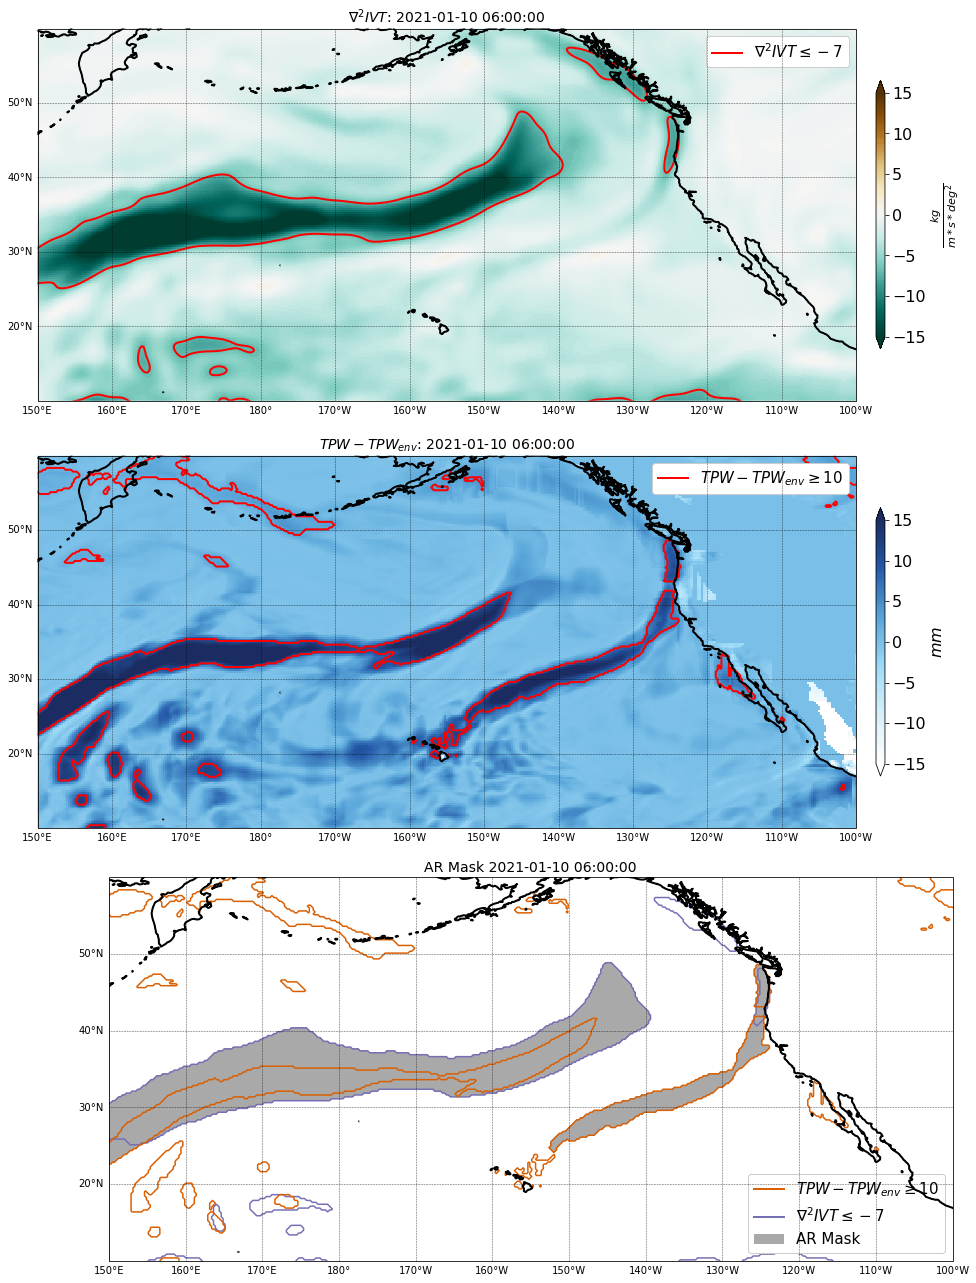

In [41]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from cartopy.feature import NaturalEarthFeature
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# import matplotlib.ticker as mticker
# import cmaps
# import numpy as np

cm = 180
minlon = 80 + cm
maxlon = -30 + cm
proj = ccrs.PlateCarree(central_longitude=cm)

# Create subplots: 3 rows, 1 column
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 18),
                        subplot_kw={'projection': proj})

political_boundaries = NaturalEarthFeature(category='cultural',
                                           name='admin_0_boundary_lines_land',
                                           scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                             name='admin_1_states_provinces_lakes',
                             scale='50m', facecolor='none')

##############################################
# 1. PLOT: ∇²IVT Filtered
##############################################
ax = axs[0]
ax.set_title(r'$\nabla^2 IVT$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.MPL_BrBG_r
css = ax.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15,
                    cmap=colormap, transform=ccrs.PlateCarree())

ax.contour(lon, lat, ivt_filtered, levels=[-7.0], colors='red',
           linestyles='-', transform=ccrs.PlateCarree(), linewidths=2)

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$\frac{kg}{m*s*deg^2}$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# 2. PLOT: AR Mask Composite
##############################################
ax = axs[2]
ax.set_title('AR Mask '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue

# AR region mask shading
ax.contourf(ar_comp_slice['lon'], ar_comp_slice['lat'], ar_comp_slice[0],
            levels=[0.5, 999], colors=['darkgrey'], transform=ccrs.PlateCarree())

# IVT mask
ax.contour(lon, lat, mask_ivt, levels=[0.5], colors='#7570b3',
           linewidths=1.5, transform=ccrs.PlateCarree())

# TPW mask
ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='#d95f02',
           linewidths=1.5, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

# Legend
tpw_legend = Line2D([0], [0], color='#d95f02', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ivt_legend = Line2D([0], [0], color='#7570b3', linewidth=2, linestyle='-', label=r'$\nabla^2 IVT \leq -7$')
ar_patch = Patch(facecolor='darkgrey', label='AR Mask')

ax.legend(handles=[tpw_legend, ivt_legend, ar_patch], loc='lower right', fontsize=15,
          frameon=True, ncol=1, framealpha=1.0)

##############################################
# 3. PLOT: TPW - TPW_env
##############################################
ax = axs[1]
ax.set_title(r'$TPW - TPW_{env}$: '+str(dt1), fontsize=14)
ax.set_extent([minlon, maxlon, 10, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='none', zorder=26)
ax.coastlines('50m', linewidth=2, zorder=24)

colormap = cmaps.WhiteBlue
css = ax.pcolormesh(lon, lat, tpw - tpw_background, vmin=-15.0, vmax=15.0,
                    cmap=colormap, transform=ccrs.PlateCarree())

# TPW thresholds
tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5 * tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax.contour(lon, lat, tpw_mask, levels=[0.5], colors='red',
           linewidths=2, transform=ccrs.PlateCarree())

cbar = fig.colorbar(css, ax=ax, orientation='vertical', aspect=30, shrink=0.7, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$mm$', fontsize=16)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.7,
                  linestyle='--', zorder=25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))

solid_line = Line2D([0], [0], color='red', linewidth=2, linestyle='-', label=r'$TPW - TPW_{env} \geq 10$')
ax.legend(handles=[solid_line], loc='upper right', fontsize=15, frameon=True, ncol=2, framealpha=1.0)

##############################################
# Final adjustments
##############################################
fig.subplots_adjust(hspace=0.25)
plt.tight_layout()
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/End_All_Plots.png", dpi=350, bbox_inches='tight')
plt.show()


## Connecting Lifecycle

In [30]:
#open up the AR that approximates this
ar_test

<xarray.Dataset>
Dimensions:                       (lat: 721, lon: 1440, time: 64, n: 1)
Coordinates:
  * n                             (n) int32 1
  * time                          (time) datetime64[ns] 2021-01-08T13:00:00 ....
  * lon                           (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
Data variables: (12/21)
    grid_area                     (lat, lon) float32 ...
    centroid_lon                  (time) float64 205.3 206.2 ... 226.9 227.5
    centroid_lat                  (time) float64 33.5 33.67 33.81 ... 34.5 34.69
    area                          (time) float64 2.296e+06 ... 1.233e+05
    largest_object_centroid_lon   (time) float64 205.3 206.2 ... 226.9 227.5
    largest_object_centroid_lat   (time) float64 33.5 33.67 33.81 ... 34.5 34.69
    ...                            ...
    lptid                         (n) float64 383.1
    duration                      (n) float64 63.0
    maxarea                       (n) float64 2.436e+06
    zonal_propagation_speed       (n) float64 7.813
    meridional_propagation_speed  (n) float64 -1.779
    mask                          (time, lat, lon) int8 ...

In [39]:
ar_mask_array=ar_test['mask']

In [40]:
ar_mask_array

<xarray.DataArray 'mask' (time: 64, lat: 721, lon: 1440)>
[66447360 values with dtype=int8]
Coordinates:
  * time     (time) datetime64[ns] 2021-01-08T13:00:00 ... 2021-01-11T04:00:00
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Attributes:
    units:    1

In [74]:
ar_test['centroid_lon'][41]

<xarray.DataArray 'centroid_lon' ()>
array(223.58508301)
Coordinates:
    time     datetime64[ns] 2021-01-10T06:00:00
Attributes:
    units:          degrees_east
    long_name:      centroid longitude (0-360)
    standard_name:  longitude
    note:           Time is end of running mean time.

Remember that I modified the end time here. If Shuyi feels like we should go to the end, or change how we talk about the ARs, make the change here

/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

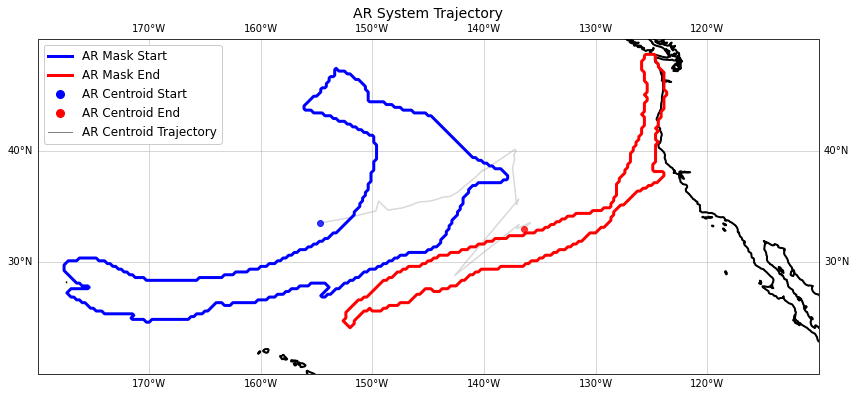

In [75]:
cm = 180
fig = plt.figure(figsize=[14, 7])
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
# Set central_longitude to 0
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('AR System Trajectory', fontsize=14)
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=10)
ax.coastlines('50m', linewidth=2, zorder=5)

# Loop through ARs
# for i in range(0,len(Pac_ars_df)):
    # ar_test = xr.open_dataset(Pac_ars_df['AR ID (string)'].iloc[i])

ar_test['centroid_lon'] = ar_test['centroid_lon'].where(ar_test['centroid_lon'] != -999)
ar_test['centroid_lat'] = ar_test['centroid_lat'].where(ar_test['centroid_lat'] != -999)

# Manually shift longitude values to center the region of interest
lon_values = ar_test['centroid_lon'][0:42].values - 180
lat_values = ar_test['centroid_lat'][0:42].values

if np.max(lon_values) > 180:
    # Split trajectory into two parts
    split_index = np.argmax(lon_values > 180)
    lon_values_part1 = lon_values[:split_index]
    lat_values_part1 = lat_values[:split_index]

    # Switch coordinates to -180 to 180 for part2
    lon_values_part2 = lon_values[split_index:] - 360
    lat_values_part2 = lat_values[split_index:]

    # Plot part1
    ax.plot(lon_values_part1, lat_values_part1, alpha=0.3, color='gray', zorder=2)

    # Plot part2
    ax.plot(lon_values_part2, lat_values_part2, alpha=0.3, color='gray', zorder=2)

else:
    # Plot the trajectory directly
    ax.plot(lon_values, lat_values, alpha=0.3, color='gray', zorder=2)

# Plot the start and end points
ax.scatter(lon_values[41], lat_values[41], alpha=0.8, color='red', zorder=3, label='End')
ax.scatter(lon_values[0], lat_values[0], alpha=0.8, color='blue', zorder=3, label='Start')
    # plt.legend()  

# plt.legend()    
ax.contour(ar_mask_array['lon'], ar_mask_array['lat'], ar_mask_array[0], [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=12, vmin=0,linewidths=3)
ax.contour(ar_mask_array['lon'], ar_mask_array['lat'], ar_mask_array[41], [0.5], colors=('red',), transform=ccrs.PlateCarree(),zorder=12, vmin=0,linewidths=3)

# Set the desired extent manually
ax.set_xlim([0, 70])
ax.set_ylim([20, 50])

ar_start_legend = Line2D([0], [0], color='blue', linewidth=3, linestyle='-', label='AR Mask Start')
ar_end_legend = Line2D([0], [0], color='red', linewidth=3, linestyle='-', label='AR Mask End')

ar_end_dot_legend = Line2D(
    [0], [0],
    color='red',            # Marker color
    marker='o',             # Circle marker
    linestyle='None',       # No line
    markersize=8,           # Size of the marker
    label='AR Centroid End' # Label with LaTeX
)

ar_start_dot_legend = Line2D(
    [0], [0],
    color='blue',            # Marker color
    marker='o',             # Circle marker
    linestyle='None',       # No line
    markersize=8,           # Size of the marker
    label='AR Centroid Start' # Label with LaTeX
)

ar_traj_legend = Line2D([0], [0], color='gray', linewidth=1, linestyle='-', label='AR Centroid Trajectory')

ax.legend(handles=[ar_start_legend,ar_end_legend,ar_start_dot_legend,ar_end_dot_legend,ar_traj_legend], loc='upper left', fontsize=12, frameon=True, ncol=1, framealpha=1.0)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5)
gl.ypadding = 5
gl.xpadding = 5
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10)[::1])
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10)[::1])

# fig.text(0.50, 0.02, 'This composite constitutes '+num_ars+' AR systems at hourly resolution June 2000 through June 2024',
#          horizontalalignment='center', wrap=True)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/Final_AR_Results/Figures/Paper_Figures/AR_Trajectory_Example.png", dpi=350, bbox_inches='tight') 
fig.show()